In [1]:
#Loading necessary libraries for the project at hand
import warnings
from azure.storage.blob import BlobClient # Connection to Azure Directory/Blob Service
from collections import Counter
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin #create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) #preprocessing 
from sklearn.decomposition import PCA as pca #dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #Discriminant Analysis
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, cross_val_score,cross_val_predict, GridSearchCV, learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin #create a box-cox transformation
from sklearn.naive_bayes import GaussianNB
from xgboost import (XGBClassifier, plot_importance)
from time import time
from pandasql import sqldf #SQL for data wrangling
import numpy as np  #linear algebra
import pandas as pd  #read and wrangling
import matplotlib.pyplot as plt #visualizations
import seaborn as sns #other visualizations
import transformers #tranformations
from scipy.stats import boxcox # data transform
from datetime import datetime, date
import os, json
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
import pylab
import scipy.stats as stats
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
import json
import chardet


%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
#Azure credential and Synthea Datasets
blob = BlobClient(account_url="https://yyyyyyyyyyyy.blob.core.windows.net",
                  container_name="cmsdata",
                  blob_name="MUP_DPR_RY21_P04_V10_DY19_NPI.csv",
                  credential="yyyyyyyyyyyyyyyyy")

In [3]:
#Open dataset
with open("MUP_DPR_RY21_P04_V10_DY19_NPI.csv", "wb") as a:
    data = blob.download_blob()
    data.readinto(a)

In [4]:
#Read CMS Datasets
cms_pd = pd.read_csv("MUP_DPR_RY21_P04_V10_DY19_NPI.csv",sep=",", encoding='Latin-1')

In [5]:
#Sample data 
cms_pd.head(5)

,PRSCRBR_NPI,Prscrbr_Last_Org_Name,Prscrbr_First_Name,Prscrbr_MI,Prscrbr_Crdntls,Prscrbr_Gndr,Prscrbr_Ent_Cd,Prscrbr_St1,Prscrbr_St2,Prscrbr_City,...,Bene_Male_Cnt,Bene_Race_Wht_Cnt,Bene_Race_Black_Cnt,Bene_Race_Api_Cnt,Bene_Race_Hspnc_Cnt,Bene_Race_Natind_Cnt,Bene_Race_Othr_Cnt,Bene_Dual_Cnt,Bene_Ndual_Cnt,Bene_Avg_Risk_Scre
0,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,96.0,130.0,73.0,NaN,NaN,0.0,NaN,56.0,158.0,2.708114
1,1003000142,Khalil,Rashid,NaN,M.D.,M,I,4126 N Holland Sylvania Rd,Suite 220,Toledo,...,96.0,162.0,92.0,NaN,19.0,0.0,NaN,157.0,125.0,1.856453
2,1003000167,Escobar,Julio,E,DDS,M,I,5 Pine Cone Rd,NaN,Dayton,...,21.0,48.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,1.140737
3,1003000175,Reyes-Vasquez,Belinda,NaN,D.D.S.,F,I,322 N Azusa Ave Ste 202,NaN,La Puente,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.764182
4,1003000282,Blakemore,Rosie,K,FNP,F,I,Tennessee Prison For Women,3881 Stewarts Lane,Nashville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.156650


In [6]:
#Data types 
cms_pd.dtypes

PRSCRBR_NPI                int64
Prscrbr_Last_Org_Name     object
Prscrbr_First_Name        object
Prscrbr_MI                object
Prscrbr_Crdntls           object
                          ...   
Bene_Race_Natind_Cnt     float64
Bene_Race_Othr_Cnt       float64
Bene_Dual_Cnt            float64
Bene_Ndual_Cnt           float64
Bene_Avg_Risk_Scre       float64
Length: 85, dtype: object

In [7]:
#Data Summary 
cms_pd.describe()

,PRSCRBR_NPI,Prscrbr_State_FIPS,Prscrbr_zip5,Prscrbr_RUCA,Tot_Clms,Tot_30day_Fills,Tot_Drug_Cst,Tot_Day_Suply,Tot_Benes,GE65_Tot_Clms,...,Bene_Male_Cnt,Bene_Race_Wht_Cnt,Bene_Race_Black_Cnt,Bene_Race_Api_Cnt,Bene_Race_Hspnc_Cnt,Bene_Race_Natind_Cnt,Bene_Race_Othr_Cnt,Bene_Dual_Cnt,Bene_Ndual_Cnt,Bene_Avg_Risk_Scre
count,1.240595e+06,1.239380e+06,1.240543e+06,1.239380e+06,1.240595e+06,1.240595e+06,1.240595e+06,1.240595e+06,1.107638e+06,957059.000000,...,891105.000000,992244.000000,518538.000000,484838.000000,507865.000000,879118.000000,385094.000000,731100.000000,731100.000000,1.240595e+06
mean,1.499846e+09,2.825288e+01,4.851353e+04,1.617964e+00,1.210729e+03,2.041469e+03,1.475477e+05,5.680552e+04,1.644383e+02,1227.308098,...,81.692795,134.373275,34.449043,7.520865,31.468437,0.415298,4.310464,64.372711,159.231944,1.551358e+00
std,2.879019e+08,1.609792e+01,3.026147e+04,3.541513e+00,2.967876e+03,4.834972e+03,4.202547e+05,1.354019e+05,4.083035e+02,2782.451318,...,187.795977,346.771072,63.536231,49.492957,105.829955,5.542976,21.968525,102.012426,421.644191,7.843697e-01
min,1.003000e+09,1.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01,1.100000e+01,0.000000e+00,1.100000e+01,1.100000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.380000e-01
25%,1.245894e+09,1.300000e+01,2.174000e+04,1.000000e+00,5.500000e+01,6.500000e+01,1.605345e+03,9.710000e+02,3.500000e+01,74.000000,...,23.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,38.000000,1.081650e+00
50%,1.497962e+09,2.800000e+01,4.522900e+04,1.000000e+00,1.980000e+02,2.430000e+02,1.057782e+04,4.720000e+03,8.700000e+01,255.000000,...,47.000000,69.000000,18.000000,0.000000,11.000000,0.000000,0.000000,40.000000,91.000000,1.355743e+00
75%,1.740841e+09,4.100000e+01,7.703000e+04,1.000000e+00,9.480000e+02,1.418067e+03,1.076349e+05,3.826350e+04,2.130000e+02,1094.000000,...,100.000000,171.000000,39.000000,0.000000,27.000000,0.000000,0.000000,77.000000,210.000000,1.793459e+00
max,1.993000e+09,7.800000e+01,9.992900e+04,9.900000e+01,4.654880e+05,4.660040e+05,3.934299e+07,5.598093e+06,1.838530e+05,399017.000000,...,77510.000000,148628.000000,9986.000000,10114.000000,28385.000000,588.000000,5748.000000,25660.000000,159281.000000,2.365335e+01


In [8]:
#Data wrangling for relevant States
a="""select * from cms_pd 
where Prscrbr_State_Abrvtn in('AK','AL','AR','AS','AZ','CA','CO','CT','DC','DE','FL','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VA','VI','VT','WA','WI','WV','WY');"""
pysqldf = lambda a: sqldf(a, globals())
cms_pd_1 = pysqldf(a)

In [9]:
#Relevant fields for modeling
b="""select distinct Tot_Clms,Tot_30day_Fills,Tot_Drug_Cst,Tot_Day_Suply,Tot_Benes,GE65_Tot_Clms,GE65_Tot_30day_Fills,GE65_Tot_Drug_Cst,GE65_Tot_Day_Suply,GE65_Tot_Benes,Brnd_Tot_Clms,Brnd_Tot_Drug_Cst,Gnrc_Tot_Clms,Gnrc_Tot_Drug_Cst,Bene_Avg_Age,Bene_Age_LT_65_Cnt,Bene_Age_65_74_Cnt,Bene_Age_75_84_Cnt,Bene_Age_GT_84_Cnt,Bene_Feml_Cnt,Bene_Male_Cnt,Bene_Race_Wht_Cnt,Bene_Race_Black_Cnt,
Bene_Race_Othr_Cnt,Bene_Dual_Cnt,Bene_Ndual_Cnt,Bene_Avg_Risk_Scre
from cms_pd_1;"""
pysqldf = lambda b: sqldf(b, globals())
cms_pd_2 = pysqldf(b)

In [10]:
dataframe=cms_pd_2
features = dataframe.columns[:-1].tolist()
print(dataframe.shape)

(1240230, 27)


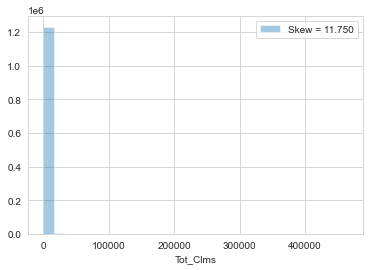

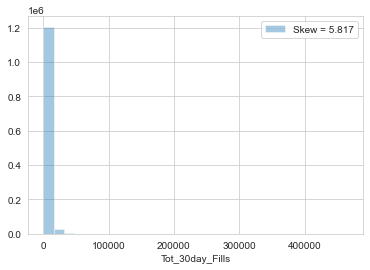

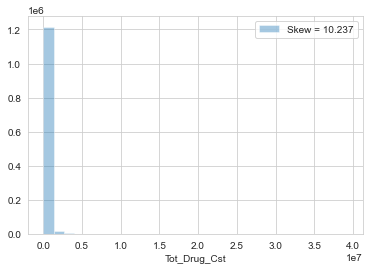

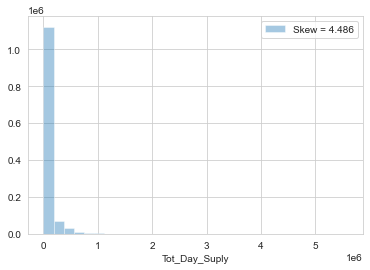

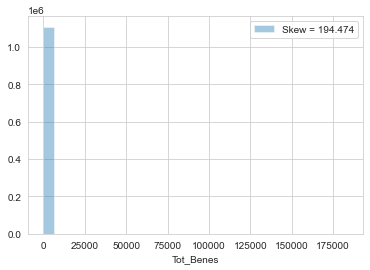

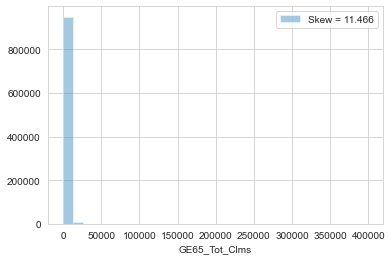

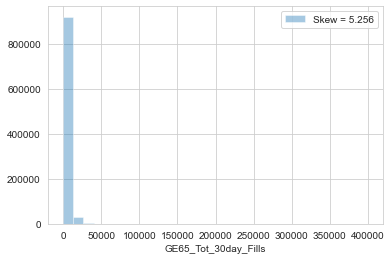

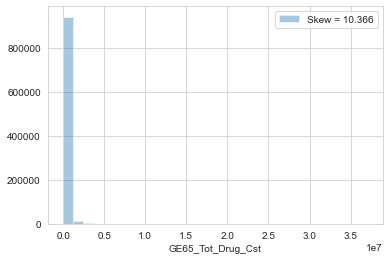

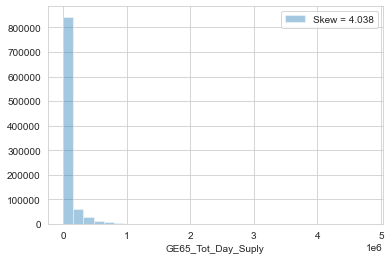

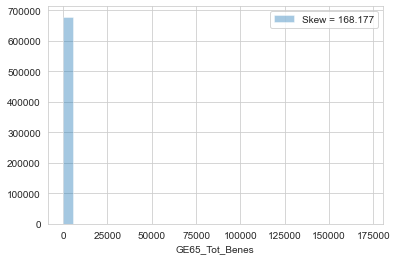

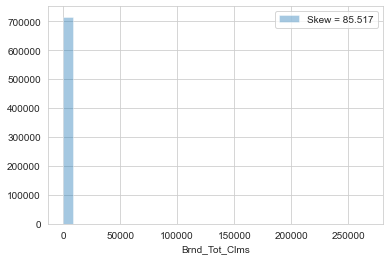

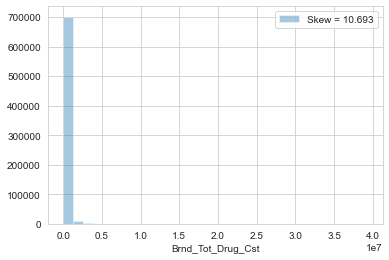

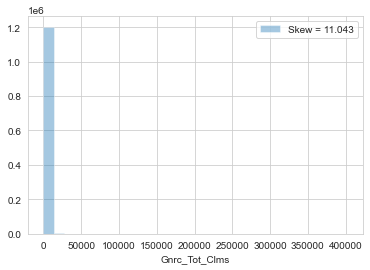

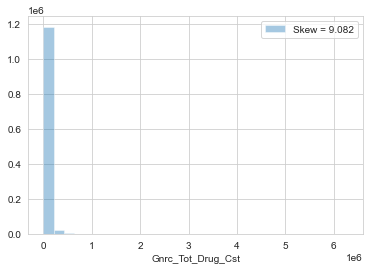

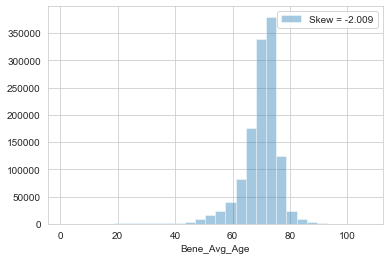

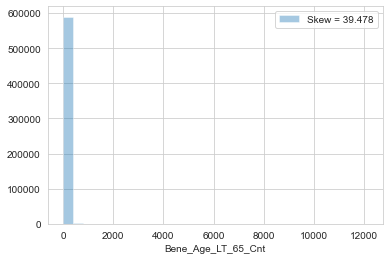

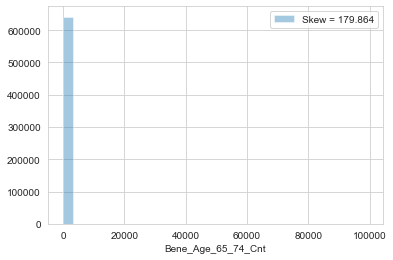

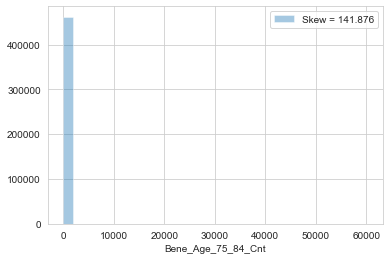

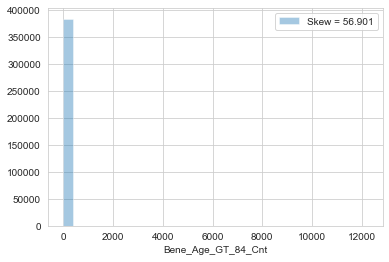

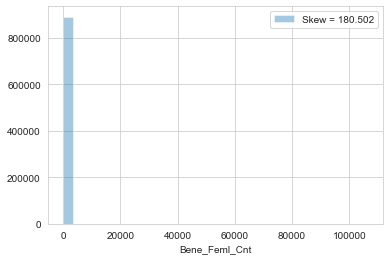

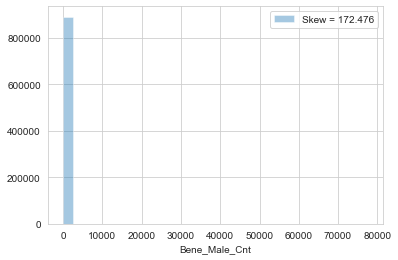

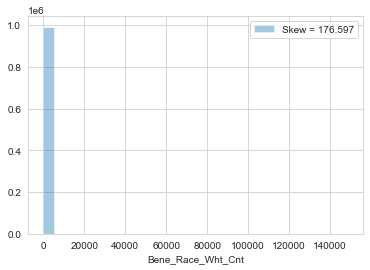

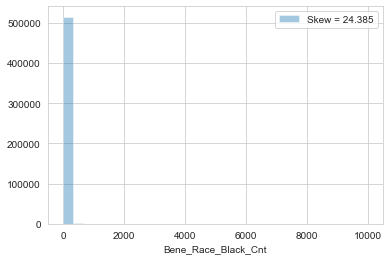

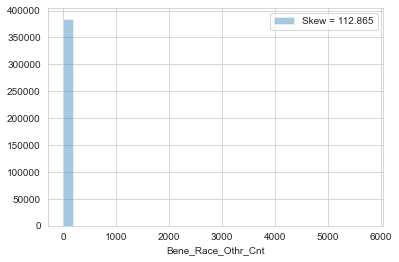

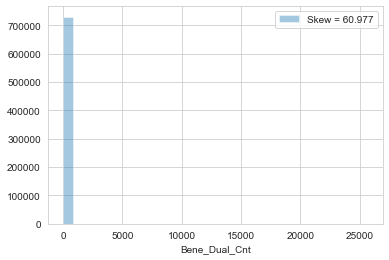

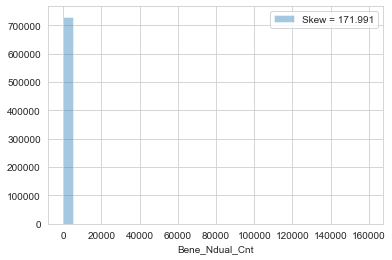

In [11]:
#Data visualization
for feat in features:
    skew = dataframe[feat].skew()
    sns.distplot(dataframe[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()
#the features are not normally distributed

In [12]:
# Detect observations with more than one outlier
#observations containing outliers using Turkey's method

def outlier_hunt(dataframe):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in dataframe.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(dataframe[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(dataframe[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(dataframe[features])))) 

The dataset contains 175942 observations with more than 2 outliers


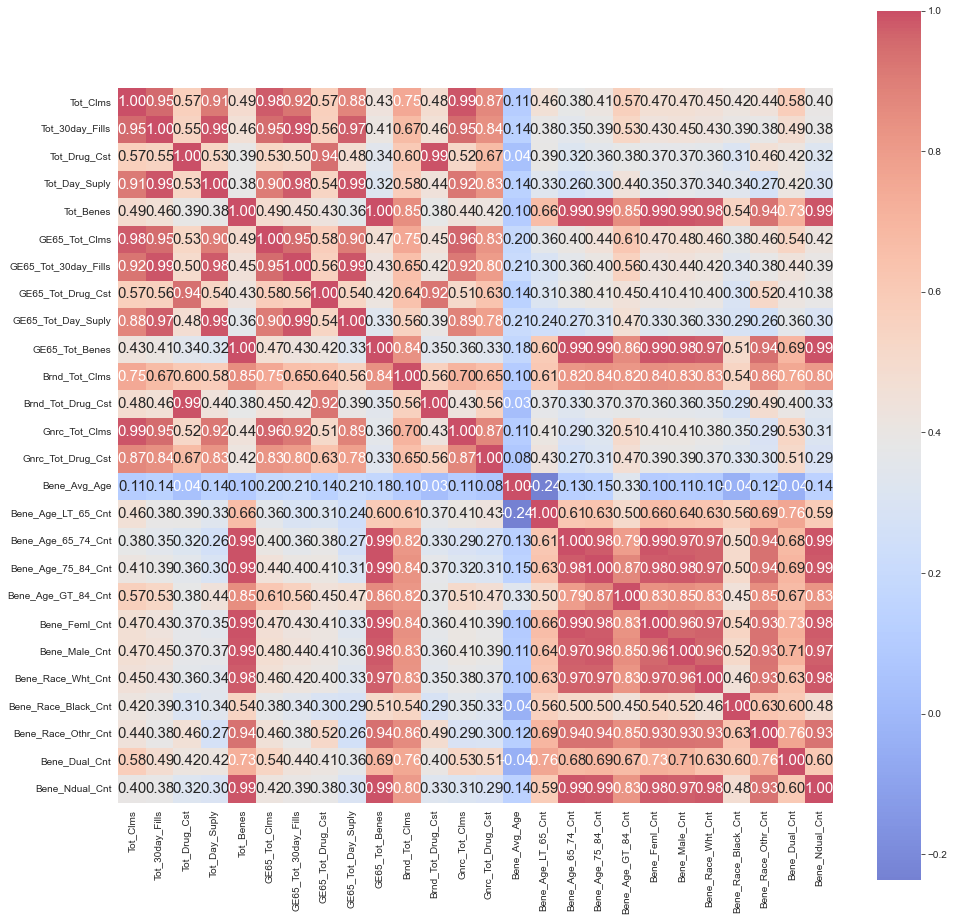

In [13]:
#Heatmaps of correlation
corr = dataframe[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

In [14]:
#Data cleaning
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240230 entries, 0 to 1240229
Data columns (total 27 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Tot_Clms              1240230 non-null  int64  
 1   Tot_30day_Fills       1240230 non-null  float64
 2   Tot_Drug_Cst          1240230 non-null  float64
 3   Tot_Day_Suply         1240230 non-null  int64  
 4   Tot_Benes             1107343 non-null  float64
 5   GE65_Tot_Clms         956816 non-null   float64
 6   GE65_Tot_30day_Fills  956816 non-null   float64
 7   GE65_Tot_Drug_Cst     956816 non-null   float64
 8   GE65_Tot_Day_Suply    956816 non-null   float64
 9   GE65_Tot_Benes        678878 non-null   float64
 10  Brnd_Tot_Clms         716200 non-null   float64
 11  Brnd_Tot_Drug_Cst     716200 non-null   float64
 12  Gnrc_Tot_Clms         1210068 non-null  float64
 13  Gnrc_Tot_Drug_Cst     1210068 non-null  float64
 14  Bene_Avg_Age          1240230 non-

In [15]:
#Hunting and removing multiple outliers
outlier_indices = outlier_hunt(dataframe[features])
dataframe = dataframe.drop(outlier_indices).reset_index(drop=True)
print(dataframe.shape)

(1064288, 27)


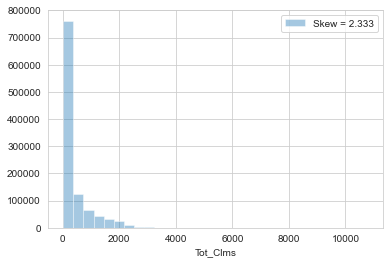

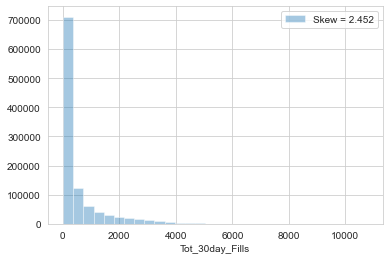

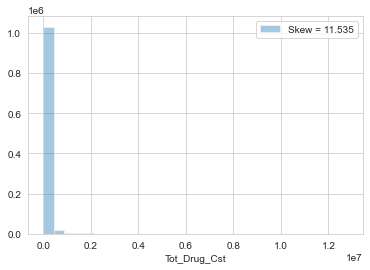

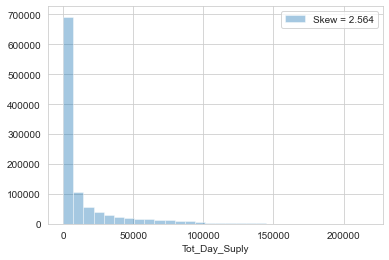

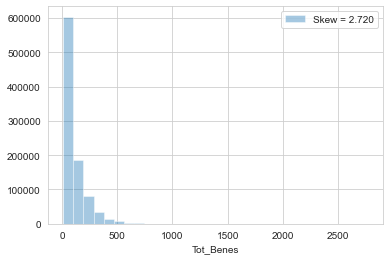

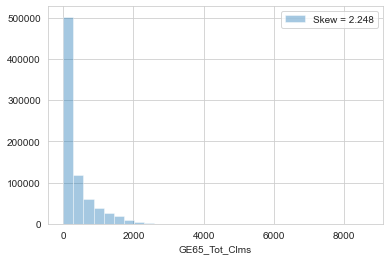

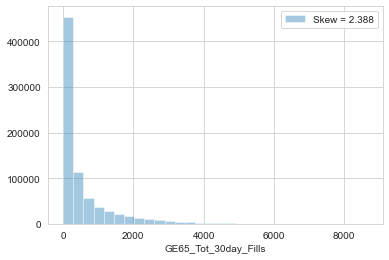

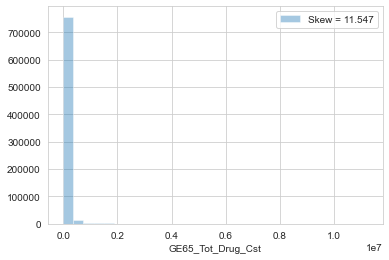

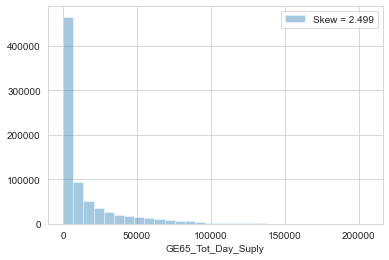

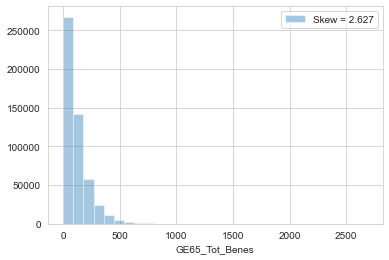

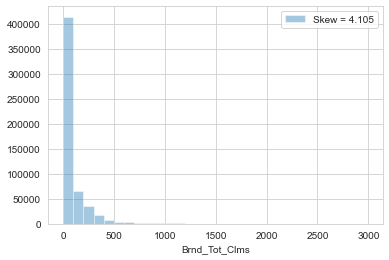

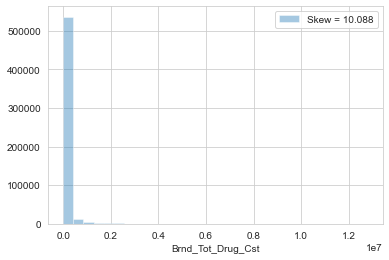

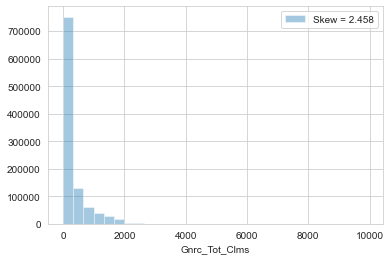

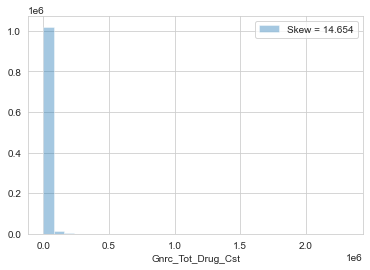

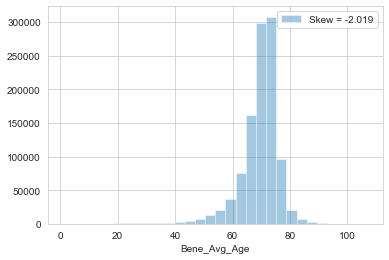

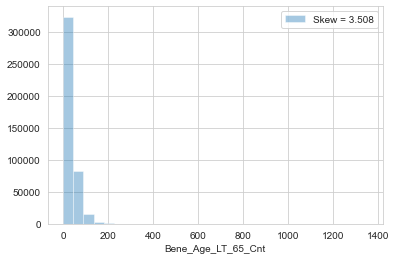

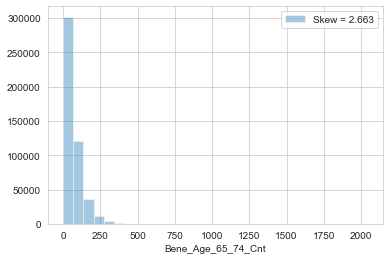

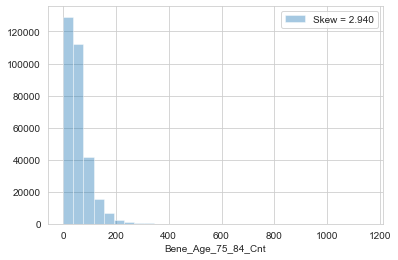

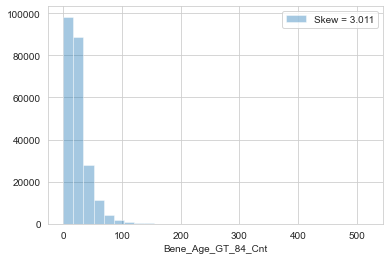

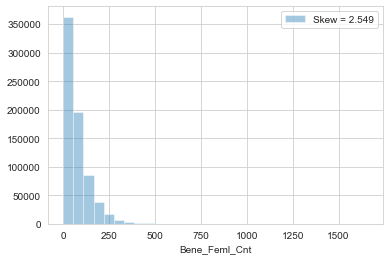

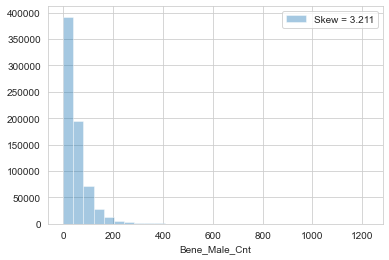

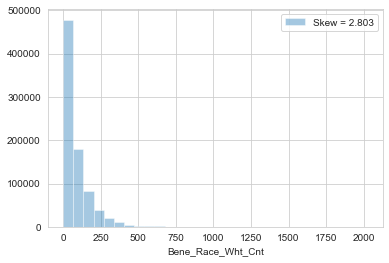

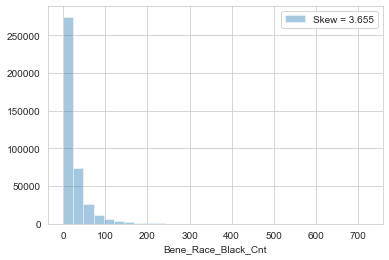

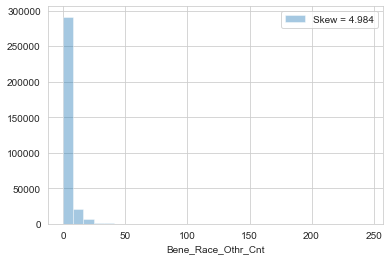

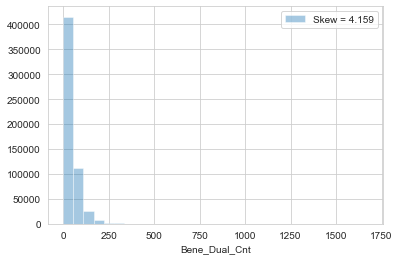

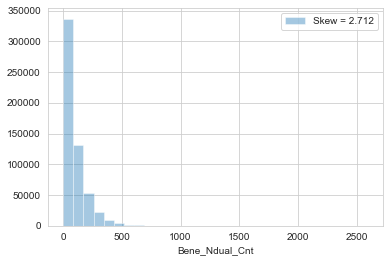

In [16]:
for feat in features:
    skew = dataframe[feat].skew()
    sns.distplot(dataframe[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [17]:
#Eliminate variables with possible multi-collinearity
#Relevant fields for modeling
c="""select distinct 
Tot_Clms,
Tot_30day_Fills,
Tot_Drug_Cst,
Tot_Benes,
Bene_Avg_Age,
Bene_Age_LT_65_Cnt,
Bene_Race_Black_Cnt,
Bene_Avg_Risk_Scre
from cms_pd_2;"""
pysqldf = lambda c: sqldf(c, globals())
df= pysqldf(c)

In [18]:
#Replace missing with median: Non-Normal distributions
df['Tot_Clms'] = df['Tot_Clms'].fillna(df['Tot_Clms'].median())
df['Tot_30day_Fills'] = df['Tot_30day_Fills'].fillna(df['Tot_30day_Fills'].median())
df['Tot_Drug_Cst'] = df['Tot_Drug_Cst'].fillna(df['Tot_Drug_Cst'].median())
df['Tot_Benes'] = df['Tot_Benes'].fillna(df['Tot_Benes'].median())
df['Bene_Avg_Age'] = df['Bene_Avg_Age'].fillna(df['Bene_Avg_Age'].median())
df['Bene_Age_LT_65_Cnt'] = df['Bene_Age_LT_65_Cnt'].fillna(df['Bene_Age_LT_65_Cnt'].median())
df['Bene_Race_Black_Cnt'] = df['Bene_Race_Black_Cnt'].fillna(df['Bene_Race_Black_Cnt'].median())
df['Bene_Avg_Risk_Scre'] = df['Bene_Avg_Risk_Scre'].fillna(df['Bene_Avg_Risk_Scre'].median())

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = df.iloc[:, :-1].values
y = df['Bene_Avg_Risk_Scre'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

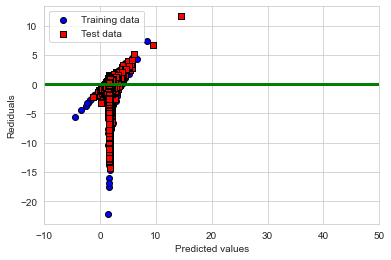

In [20]:
%matplotlib inline
plt.scatter(y_train_pred, y_train_pred-y_train, 
           c='blue', marker='o', edgecolor='k', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='red', marker='s', edgecolor='k', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Rediduals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=3, color='green')
plt.xlim([-10, 50])
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print(f'Overfitting indicator: {mean_squared_error(y_test, y_test_pred)} > {mean_squared_error(y_train, y_train_pred)}')

MSE train: 0.599, test: 0.598
Overfitting indicator: 0.5975509041878861 > 0.5993231485657818


In [22]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

R^2 train: 0.027, test: 0.026


In [23]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue', edgecolor='black', alpha=0.4)
    plt.plot(X, model.predict(X), color='red')
    return None

In [24]:
#Dealing with nonlinear relationships using random forests

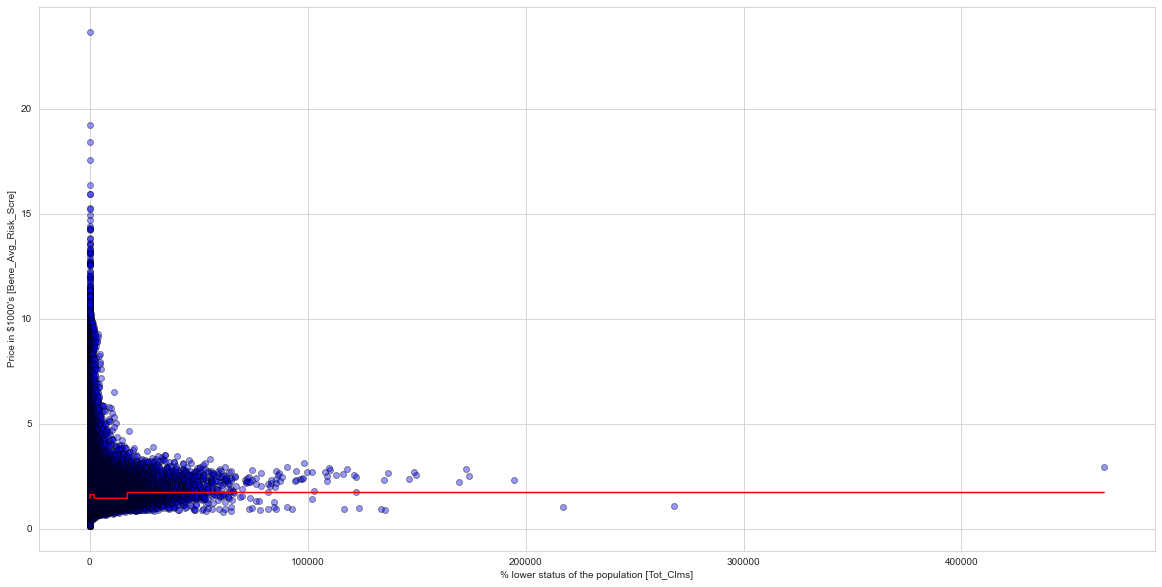

In [25]:
from sklearn.tree import DecisionTreeRegressor
X = df[['Tot_Clms']].values
y = df['Bene_Avg_Risk_Scre'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
plt.figure(figsize=(20, 10))
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [Tot_Clms]')
plt.ylabel('Price in $1000\'s [Bene_Avg_Risk_Scre]')
plt.show()

In [ ]:
#Random forest regression
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['Bene_Avg_Risk_Scre'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse',
                               random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

In [27]:
#Model outputs for dashboarding
d="""select Prscrbr_Last_Org_Name,
Prscrbr_First_Name,
Prscrbr_Gndr,
Prscrbr_St1,
Prscrbr_City,
Prscrbr_State_Abrvtn,
Prscrbr_zip5,
Prscrbr_Type,
Bene_Avg_Risk_Scre from cms_pd_1;"""
pysqldf = lambda d: sqldf(d, globals())
CMS_MUP_D_Subset = pysqldf(d)

In [28]:
#Export Final_Results to csv
CMS_MUP_D_Subset.to_csv(r'C:\Users\olajideajayi\OneDrive - Microsoft\Desktop\WIP\CMS Data\MUP_PHY_RY21\CMS_MUP_D_Subset.csv', index = False)